## Import Libraries

In [1]:
# import the library 
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model, layers, datasets
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature
import rawpy
import ipywidgets as widgets
from IPython.display import display

# Marching cube 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from skimage.draw import ellipsoid

from fringe.utils.io import import_image, export_image
from fringe.utils.modifiers import ImageToArray, ConvertToTensor
from fringe.process.gpu import AngularSpectrumSolver as AsSolver

2025-04-30 22:40:04.494618: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/chuckles/holoVirtualEnv/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load DNG Images

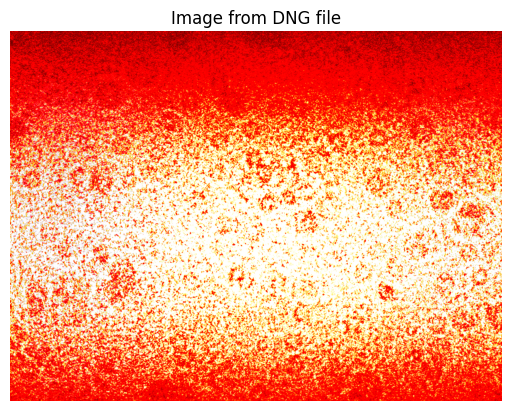

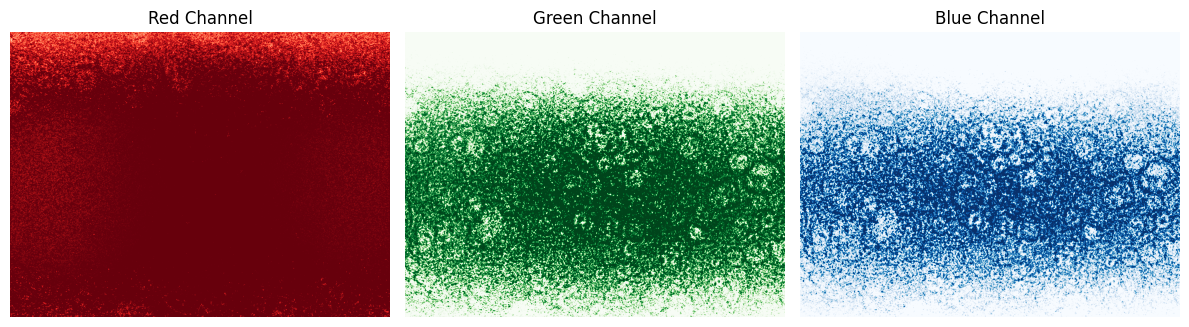

In [2]:
# Load the DNG file
file_path = '/Users/chuckles/holoVirtualEnv/holoimg/04-30-222233-testyeastdiluted.dng'
background_path = '/Users/chuckles/holoVirtualEnv/holoimg/background.dng'

# file_path = '/Users/chuckles/holoVirtualEnv/holoimg/03-06-112131-target_closer.dng'
with rawpy.imread(file_path) as raw:
    # Convert the raw image to a RGB array
    rgb = raw.postprocess()

with rawpy.imread(background_path) as raw:
    # Convert the raw image to a RGB array
    bg = raw.postprocess()

bg_average = np.mean(bg, axis=(0, 1))
captured_img = rgb - bg_average

captured_img = rgb

# Display the image
plt.imshow(captured_img)
plt.axis('off')  # Hide axis
plt.title('Image from DNG file')  # Optional title
plt.show()

try:
    with rawpy.imread(file_path) as raw:
        # Convert the raw image to a RGB array with camera white balance
        rgb = raw.postprocess(use_camera_wb=True, output_color=rawpy.ColorSpace.sRGB)

    # Separate the RGB channels
    red_channel = rgb[:, :, 0]   # Red channel
    green_channel = rgb[:, :, 1] # Green channel
    blue_channel = rgb[:, :, 2]  # Blue channel

    # Display each channel
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(red_channel, cmap='Reds')
    plt.axis('off')
    plt.title('Red Channel')

    plt.subplot(1, 3, 2)
    plt.imshow(green_channel, cmap='Greens')
    plt.axis('off')
    plt.title('Green Channel')

    plt.subplot(1, 3, 3)
    plt.imshow(blue_channel, cmap='Blues')
    plt.axis('off')
    plt.title('Blue Channel')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

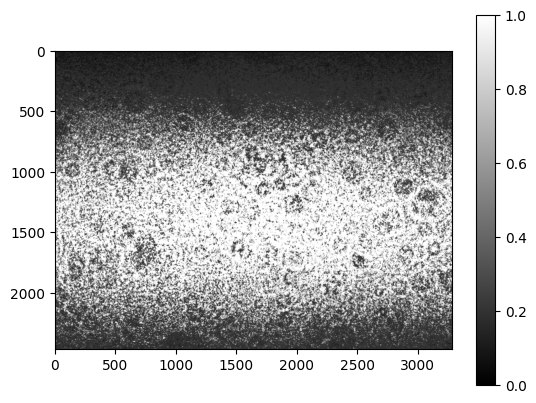

In [3]:
gray_image = 0.25 * captured_img[:, :, 0] + 0.250 * captured_img[:, :, 1] + 0.50 * captured_img[:, :, 2]

def im2double(im):
    min_val = np.min(im.ravel())
    max_val = np.max(im.ravel())
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out
gray_image = im2double(gray_image)

#add color bar
plt.imshow(gray_image, cmap='gray')
plt.colorbar()

In [7]:
# Use Fringe to solve for the object slices
# folder_path = '/Users/chuckles/Desktop/Holographic Reconstruction/DHM-fieldimage/sprinlina-02-15-24/'
# file_name = '160439feb15Spr10xDilution'

# folder_path = '/Users/chuckles/holoVirtualEnv/holoimg/'
# file_name ='image15_905'
# hologram_path = folder_path+file_name+'.jpg'

# p1 = ImageToArray(bit_depth=16, channel='gray', crop_window=None, dtype='float32')
# hologram = import_image(hologram_path, modifiers=[p1])
hologram = gray_image

def Scale(img, perc, max_val):
	img *= perc
	img += 1 - perc
	img /= max_val
	return img

def generate_stack (hologram, z_distance):
    hologram_amp = tf.math.abs(hologram)
    solver = AsSolver(shape=hologram_amp.shape, dx=1.12, dy=1.12, wavelength=650e-3)
      
    # Adjusting contrast
    hologram_amp = Scale(hologram_amp, perc=1, max_val=np.max(hologram_amp))

    rec = solver.solve(hologram, z_distance)
    amp = np.abs(rec)

    return amp

holo_list = []

z_layers = range (5000, 10000, 200) 

for i in z_layers:
    next_holo = generate_stack(hologram, i)
#     print(np.shape(next_holo_expanded))
#     print(f"Stacking hologram at {i}")
    holo_list.append(next_holo)

stacked_holo = np.stack([holo_list], axis = 0)
print(np.shape(stacked_holo[0]))

(25, 2464, 3280)


In [5]:
# Image helper function, soft threshold and norm image
def norm_image (image):
    min_value = np.min(image)
    max_value = np.max(image)
    norm = (image - min_value) / (max_value - min_value)
    return np.max(norm) - norm

def soft_threshold(x, threshold, range_width):
    """
    Apply soft thresholding to an array.
    
    Parameters:
    x: Input array
    threshold: Center of the threshold range
    range_width: Width of the threshold range
    
    Returns:
    Soft thresholded array
    """
    lower = threshold - range_width/2
    upper = threshold + range_width/2
    
    result = np.zeros_like(x)
    
    # Values below lower bound are set to 0
    result[x < lower] = 0
    
    # Values above upper bound remain unchanged
    result[x >= upper] = x[x >= upper]
    
    # Values in between are scaled
    mask = (x >= lower) & (x < upper)
    result[mask] = (x[mask] - lower) / range_width * x[mask]
    
    return result

data_list = stacked_holo[0]

# fig, axs = plt.subplots(4, 5, figsize=(12, 12))

# norm_holo_list = np.empty((905, 905))

# for i, data in enumerate(data_list):
#     data = threshold_image(norm_image (data), 0.6)
#     # np.concatenate(norm_holo_list, data)
#     # print(np.shape(norm_holo_list))
#     # norm_holo_list.append(data)
#     ax = axs.flat[i]
#     ax.imshow(data, cmap='viridis')
#     ax.set_title(f'Map {i+1}')

# plt.show()

In [ ]:
images = stacked_holo[0]
# images_threshold = stacked_holo[0]
num_images = np.shape(images)[0]

# Create a function to display the selected image
def display_image(index):
    # # Apply soft thresholding
    # threshold = 0.50
    # range_width = 0.40
    # images_threshold[index] = (soft_threshold(images[index], threshold, range_width))

    # Update the title based on the current index (z_layer)
    plt.title(f"Image at distance: {z_layers[index]} um ")
    plt.imshow(images[index], cmap='gray')
    plt.axis('off')
    plt.colorbar()
    plt.show()

def save_image(index):
    plt.imsave(f'saved_image_{index}.jpg', images[index], cmap='gray')
    print(f'Image saved as saved_image_{index}.jpg')

# Create a slider for selecting the image index
image_slider = widgets.IntSlider(value=0, min=0, max=len(images)-1, step=1, description='Image Index')

# Create a button to save the image
save_button = widgets.Button(description="Save Image")

# Link the button click event to the save_image function
def on_save_button_click(b):
    save_image(image_slider.value)

save_button.on_click(on_save_button_click)

# Create an interactive widget
interactive_display = widgets.interactive(display_image, index=image_slider)

# Display the slider and the save button
display(save_button)
display(interactive_display)


Button(description='Save Image', style=ButtonStyle())

interactive(children=(IntSlider(value=0, description='Image Index', max=24), Output()), _dom_classes=('widget-…

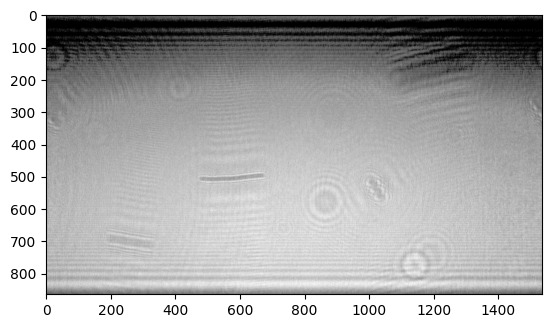

In [48]:
plt.imshow(soft_threshold(images[7], 0.2, 0.1), cmap='gray')

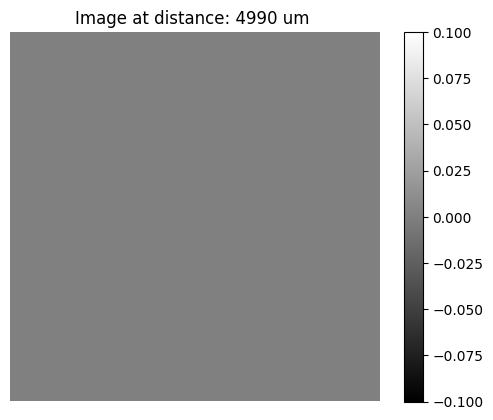

In [21]:
# Find edge
import cv2

images_edge_finder = stacked_holo[0]

# Create a function to display the selected image
def canny_edgefinder(index):
    # Step 1: Load the image
    image = stacked_holo[0][index]

    # Step 1: Scale the array to the range [0, 255]
    gray_image = (image * 255).astype(np.uint8)

    # Step 3: Apply Gaussian Blur
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Step 4: Use Canny edge detection
    images_edge_finder [index] = cv2.Canny(blurred_image, 100, 200)

    # Update the title based on the current index (z_layer)
    plt.title(f"Image at distance: {z_layers[index]} um ")
    plt.imshow(images_edge_finder[index], cmap='gray')
    plt.axis('off')
    plt.colorbar()
    plt.show()

canny_edgefinder(49)

In [ ]:
from skimage import measure

# Define the isosurface value
iso_value = 0.5  # Adjust based on your data

# Apply the Marching Cubes algorithm
verts, faces, _, _ = measure.marching_cubes(images_threshold, iso_value)

# Plotting the result
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, color='cyan', edgecolor='k', alpha=0.5)

# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('Marching Cubes Isosurface from Image Stack')

plt.show()

## Custom Propagation


In [6]:
def unwrap(x):
    y = x % (2 * np.pi)
    return torch.where(y > np.pi, 2*np.pi - y, y)

def fft2dc(x):
    return np.fft.fftshift(np.fft.fft2(x))

def ifft2dc(x):
    return np.fft.ifft2(np.fft.fftshift(x))

def Phase_unwrapping(in_):
    f = np.zeros((1000,1000))
    for ii in range(1000):
        for jj in range(1000):
            x = ii - 1000/2
            y = jj - 1000/2
            f[ii,jj] = x**2 + y**2
    a = ifft2dc(fft2dc(np.cos(in_)*ifft2dc(fft2dc(np.sin(in_))*f))/(f+0.000001))
    b = ifft2dc(fft2dc(np.sin(in_)*ifft2dc(fft2dc(np.cos(in_))*f))/(f+0.000001))
    out = np.real(a - b)
    return out

def propagator(Nx,Ny,z,wavelength,deltaX,deltaY):
    k = 1/wavelength
    x = np.expand_dims(np.arange(np.ceil(-Nx/2),np.ceil(Nx/2),1)*(1/(Nx*deltaX)),axis=0)
    y = np.expand_dims(np.arange(np.ceil(-Ny/2),np.ceil(Ny/2),1)*(1/(Ny*deltaY)),axis=1)
    y_new = np.repeat(y,Nx,axis=1)
    x_new = np.repeat(x,Ny,axis=0)
    kp = np.sqrt(y_new**2+x_new**2)
    term=k**2-kp**2
    term=np.maximum(term,0)
    phase = np.exp(1j*2*np.pi*z*np.sqrt(term))
    return phase

In [10]:
#um
Nx = np.shape(rgb)[1]
Ny = np.shape(rgb)[0]
z = 4800
wavelength = 0.650
deltaX = 1.12
deltaY = 1.12

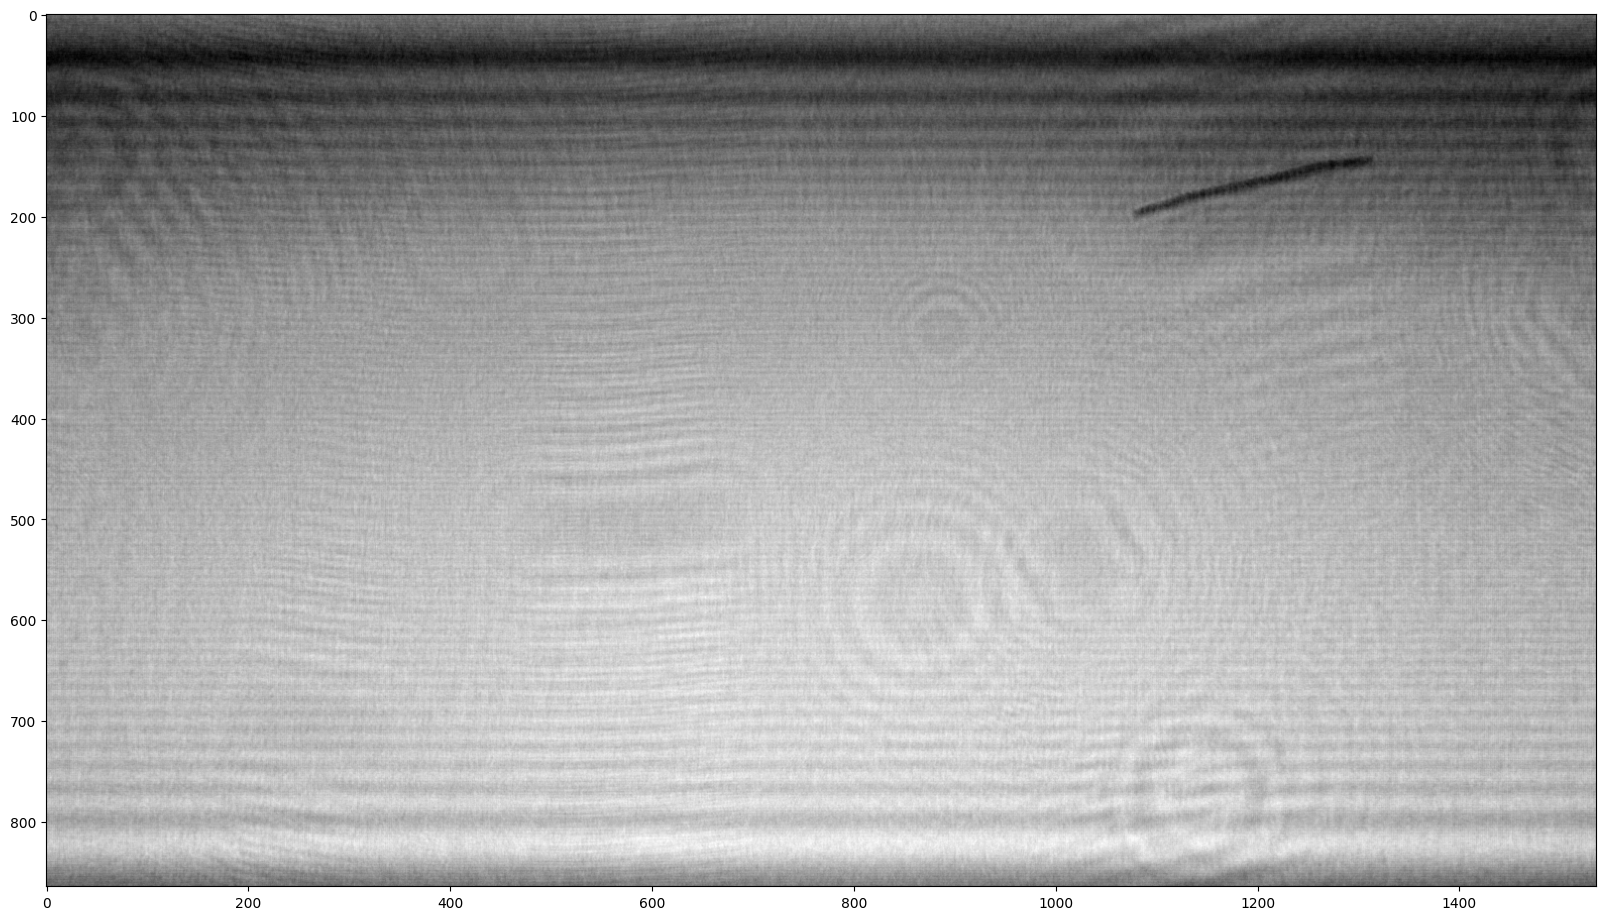

In [11]:
phase = propagator(Nx,Ny,z,wavelength,deltaX,deltaY)
eta = np.fft.ifft2(np.fft.fft2(gray_image)*np.fft.fftshift(np.conj(phase)))
plt.figure(figsize=(20,15))
plt.imshow(np.squeeze(np.abs(eta)), cmap='gray')

In [ ]:
def angular_spectrum_propagation(field, dx, dy, wavelength, z):
    Ny, Nx = field.shape
    kx = 2 * np.pi * np.fft.fftfreq(Nx, dx)
    ky = 2 * np.pi * np.fft.fftfreq(Ny, dy)
    kx, ky = np.meshgrid(kx, ky)
    
    k = 2 * np.pi / wavelength
    kz = np.sqrt(k**2 - kx**2 - ky**2 + 0j)
    kz = np.real(kz) - 1j * np.abs(np.imag(kz))
    
    H = np.exp(1j * kz * z)
    U = np.fft.fft2(field)
    U_prop = U * H
    return np.fft.ifft2(U_prop)

# start with an initial guess
# the measure image is the fourier domain of the object image

dx = 1.12 #um pixel size
wavelength = 0.650 #um
z = 5000 #distance
Nx, Ny = np.shape(gray_image)

measured_intensity = np.sqrt(gray_image)

# Create initial guess with random phase
object_mag = abs(angular_spectrum_propagation(gray_image, dx, dx, wavelength, z))
random_phase = np.random.uniform(0, 2 * np.pi, (Nx, Ny))
object_initial_guess = object_mag * np.exp(1j * random_phase)

for i in range(200):
    # Propagate into measurement plane
    measurement = angular_spectrum_propagation(object_initial_guess, dx, dx, wavelength, -z)

    # Apply Fouier domain constrain, but keep the updated phase
    new_measurement = measured_intensity * np.exp(1j * np.angle(measurement))

    # Reverse back into object domain 
    new_object = angular_spectrum_propagation(new_measurement, dx, dx, wavelength, z)
    # apply object domain constraint, negative value to 0
    
    object_initial_guess = np.clip(new_object, a_min=0, a_max=None)

In [ ]:
plt.imshow(abs(object_initial_guess))
plt.colorbar()

In [12]:


def soft_threshold(x, alpha):
    return np.sign(x) * np.maximum(np.abs(x) - alpha, 0)

def normalize_0_1(x):
    x_abs = np.abs(x)
    return (x_abs - np.min(x_abs)) / (np.max(x_abs) - np.min(x_abs))

def fienup_method_asp(measured_magnitude, initial_guess, wavelength, z, dx, dy, max_iterations=100, beta=0.8, alpha=0.1, epsilon=1e-6):
    current = initial_guess.copy()
    error_list = []
    
    for iteration in range(max_iterations):
        # Forward propagation using ASP
        propagated = angular_spectrum_propagation(current, dx, dy, wavelength, z)
        
        # Apply Fourier constraint
        constrained = measured_magnitude * np.exp(1j * np.angle(propagated))
        
        # Inverse propagation using ASP
        inverse_propagated = angular_spectrum_propagation(constrained, dx, dy, wavelength, -z)
        
        # Apply soft thresholding
        thresholded = soft_threshold(inverse_propagated, alpha)
        
        # Apply object domain constraints
        next_estimate = np.where(np.abs(thresholded) < epsilon,
                                 current - beta * thresholded,
                                 thresholded)
        
        # Normalize the estimate between 0 and 1
        next_estimate = normalize_0_1(next_estimate)
        
        # Update current estimate
        current = next_estimate
        
        # Calculate error
        error = np.sum(np.abs(np.abs(propagated) - measured_magnitude)**2) / np.sum(measured_magnitude**2)
        error_list.append(error)
        
        if iteration % 10 == 0:
            print(f"Iteration {iteration}, Error: {error:.6f}")
    
    return current, error_list

# Example usage
if __name__ == "__main__":
    Nx, Ny = np.shape(gray_image)
    dx = dy = 1.12  # um pixel size
    wavelength = 0.650 # um (He-Ne laser)
    z =  5000 # um (distance from object to detector)
    
    # Create measured magnitude
    # measured_magnitude = np.abs(angular_spectrum_propagation(gray_image, dx, dy, wavelength, z))
    measured_magnitude = np.sqrt(gray_image)

    # Create initial guess
    initial_guess = np.random.rand(Nx, Ny)
    
    # Run Fienup method with ASP
    reconstructed, errors = fienup_method_asp(measured_magnitude, initial_guess, wavelength, z, dx, dy, max_iterations=200, beta=0.8, alpha=0.1)
    
    # Plot results
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    im1 = ax1.imshow(gray_image, cmap='viridis', vmin=0, vmax=1)
    ax1.set_title("Original Object")
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(reconstructed, cmap='viridis', vmin=0, vmax=1)
    ax2.set_title("Reconstructed Object")
    fig.colorbar(im2, ax=ax2)
    
    ax3.semilogy(errors)
    ax3.set_title("Error vs. Iteration")
    ax3.set_xlabel("Iteration")
    ax3.set_ylabel("Error")
    
    plt.tight_layout()
    plt.show()

NameError: name 'angular_spectrum_propagation' is not defined

In [ ]:
# Load the image
image_path = '/Users/chuckles/holoVirtualEnv/holoimg/GeneratedTest.jpg'  # Replace with your image path
object_plane = pil.image.open(image_path)

# Display the image
plt.imshow(object_plane)
plt.axis('off')  # Hide axes
plt.show()


intensity = (angular_spectrum_propagation(object_plane, 1.12, 1.12, 0.650, 5000)^2)

## 3D reconstruction

In [ ]:
import skimage as ski
from skimage import data, img_as_float
from skimage import exposure

plt.rcParams['font.size'] = 8

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram."""
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

# Load an example image
img = img_as_float(stacked_holo[0][13])

# Gamma
gamma_corrected = exposure.adjust_gamma(img, 2)

# Logarithmic
logarithmic_corrected = exposure.adjust_log(img, 10)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(gamma_corrected, axes[:, 1])
ax_img.set_title('Gamma correction')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(logarithmic_corrected, axes[:, 2])
ax_img.set_title('Logarithmic correction')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [51]:
from skimage import measure
from mpl_toolkits.mplot3d import Axes3D

print(np.shape(images))
print(type(stacked_holo[0]))

# Assume you have a 3D tensor with shape (10, 905, 905)
tensor = images

min_val = np.min(tensor)
max_val = np.max(tensor)
print(f"Min value: {min_val}, Max value: {max_val}")
level = (np.max(tensor) - np.min(tensor)) * 0.5 + np.min(tensor)

# # Generate a level set about zero of two identical ellipsoids in 3D
# ellip_base = ellipsoid(6, 10, 16, levelset=True)
# tensor = np.concatenate((ellip_base[:-1, ...], ellip_base[2:, ...]), axis=0)
# level = 0

# Use the Marching Cubes algorithm to visualize the tensor
verts, faces, normals, values = measure.marching_cubes(tensor, level=level)

(30, 864, 1536)
<class 'numpy.ndarray'>
Min value: 0.00012357298692222685, Max value: 0.8942106366157532


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the image using PIL
image_path = 'path_to_your_image.png'
img = stacked_holo[0][13]

# Convert the image to grayscale and numpy array for processing
img_cv = np.array(img)

# Ensure that the image is in 8-bit format (CV_8U)
img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Detect edges in the image using Canny edge detection
edges = cv2.Canny(img_cv, threshold1=30, threshold2=100)

# Find contours (the outlines of the objects)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on a copy of the original image
traced_img = cv2.cvtColor(img_cv, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR for colored drawing
cv2.drawContours(traced_img, contours, -1, (0, 255, 0), 2)  # Draw contours in green

# Display the image with the contours
plt.imshow(traced_img)
plt.axis('off')  # Hide the axes
plt.show()

In [ ]:
import plotly.graph_objects as go

# Assuming verts, faces, normals, values are the output of measure.marching_cubes

# Create a mesh from the vertices and faces
mesh = go.Mesh3d(
    x=verts[:, 0],
    y=verts[:, 1],
    z=verts[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    colorscale='Viridis',
    intensity=values,
    showscale=True
)

# Create a figure with the mesh
fig = go.Figure(data=[mesh])

fig.update_layout(
    scene = dict(
        xaxis=dict(range=[-200, 200]),
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
    title='Marching Cubes',
    width=800,
    height=800
)

In [6]:
2*np.sqrt(16-4)-np.pi*4*(1/2)


0.6450179230959225